In [1]:
# Cell 1: Setup and Data Preparation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import nibabel as nib

# Set up directories
study_dir = "/lab_data/behrmannlab/vlad/ptoc"
residual_dir = "/user_data/csimmon2/ptoc_residuals"
results_dir = "/user_data/csimmon2/git_repos/ptoc/results"
curr_dir = "/user_data/csimmon2/git_repos/ptoc"

# Parameters
hemispheres = ['left', 'right']

# Load subjects (excluding sub-084)
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subjects = [sub for sub in sub_info[sub_info['group'] == 'control']['sub'].tolist() if sub != 'sub-084']

print(f"Setup complete!")
print(f"Subjects: {len(subjects)}")
print(f"Directories configured")

# Define dice coefficient function
def dice_coefficient(img1_data, img2_data):
    """Calculate Dice coefficient - same as throughout analysis"""
    img1_bin = (img1_data > 0).astype(int)
    img2_bin = (img2_data > 0).astype(int)
    intersection = np.sum(img1_bin * img2_bin)
    dice = 2.0 * intersection / (np.sum(img1_bin) + np.sum(img2_bin))
    return dice

print("Functions defined!")
print("Ready for analysis")

Setup complete!
Subjects: 18
Directories configured
Functions defined!
Ready for analysis


In [2]:
# Cell 2: Calculate Within-Subject Independent Overlap
# This calculates pIPS_clean vs LO_clean overlap within the same subjects

print("WITHIN-SUBJECT INDEPENDENT OVERLAP ANALYSIS")
print("="*50)

within_subject_dice = []
within_subject_subjects = []

for sub in subjects:
    try:
        # Load cleaned pIPS data (both hemispheres)
        pips_data = []
        for hemi in hemispheres:
            pips_file = f"{residual_dir}/{sub}/ses-01/derivatives/fc_mni/{sub}_pIPS_clean_{hemi}_loc_fc_mni.nii.gz"
            if os.path.exists(pips_file):
                img = nib.load(pips_file)
                pips_data.append(img.get_fdata())
        
        # Load cleaned LO data (both hemispheres)
        lo_data = []
        for hemi in hemispheres:
            lo_file = f"{residual_dir}/{sub}/ses-01/derivatives/fc_mni/{sub}_LO_clean_{hemi}_loc_fc_mni.nii.gz"
            if os.path.exists(lo_file):
                img = nib.load(lo_file)
                lo_data.append(img.get_fdata())
        
        # Average hemispheres and calculate dice
        if len(pips_data) == 2 and len(lo_data) == 2:
            pips_avg = (pips_data[0] + pips_data[1]) / 2
            lo_avg = (lo_data[0] + lo_data[1]) / 2
            
            dice = dice_coefficient(pips_avg, lo_avg)
            within_subject_dice.append(dice)
            within_subject_subjects.append(sub)
            
            print(f"  {sub}: {dice:.3f}")
        else:
            print(f"  {sub}: Missing data")
            
    except Exception as e:
        print(f"  {sub}: Error - {e}")

# Calculate statistics
within_mean = np.mean(within_subject_dice)
within_std = np.std(within_subject_dice)

print(f"\nWITHIN-SUBJECT INDEPENDENT OVERLAP RESULTS:")
print(f"Mean: {within_mean:.3f} ({within_mean:.1%})")
print(f"Std:  {within_std:.3f} ({within_std:.1%})")
print(f"N subjects: {len(within_subject_dice)}")

# Store results
within_subject_results = {
    'dice_values': within_subject_dice,
    'subjects': within_subject_subjects,
    'mean': within_mean,
    'std': within_std,
    'n': len(within_subject_dice)
}

print("Within-subject analysis complete!")

WITHIN-SUBJECT INDEPENDENT OVERLAP ANALYSIS
  sub-025: 0.420
  sub-038: 0.678
  sub-057: 0.792
  sub-059: 0.795
  sub-064: 0.754
  sub-067: 0.772
  sub-068: 0.763
  sub-071: 0.871
  sub-083: 0.658
  sub-085: 0.692
  sub-087: 0.588
  sub-088: 0.801
  sub-093: 0.691
  sub-094: 0.771
  sub-095: 0.822
  sub-096: 0.581
  sub-097: 0.607
  sub-107: 0.658

WITHIN-SUBJECT INDEPENDENT OVERLAP RESULTS:
Mean: 0.706 (70.6%)
Std:  0.107 (10.7%)
N subjects: 18
Within-subject analysis complete!


In [3]:
# Cell 3: Calculate Between-Subject Dorsal Overlap
# This compares pIPS_clean maps across different subjects

print("BETWEEN-SUBJECT DORSAL (pIPS_clean) OVERLAP ANALYSIS")
print("="*55)

# Load all subjects' cleaned pIPS data
dorsal_data = {}
dorsal_subjects = []

for sub in subjects:
    try:
        # Load cleaned pIPS data (both hemispheres)
        pips_data = []
        for hemi in hemispheres:
            pips_file = f"{residual_dir}/{sub}/ses-01/derivatives/fc_mni/{sub}_pIPS_clean_{hemi}_loc_fc_mni.nii.gz"
            if os.path.exists(pips_file):
                img = nib.load(pips_file)
                pips_data.append(img.get_fdata())
        
        # Average hemispheres
        if len(pips_data) == 2:
            pips_avg = (pips_data[0] + pips_data[1]) / 2
            dorsal_data[sub] = pips_avg
            dorsal_subjects.append(sub)
        else:
            print(f"  Missing pIPS_clean data for {sub}")
            
    except Exception as e:
        print(f"  Error loading {sub}: {e}")

print(f"Loaded dorsal data for {len(dorsal_subjects)} subjects")

# Calculate all pairwise dice coefficients
between_dorsal_dice = []
dorsal_pairs = []

print("Calculating pairwise comparisons...")
for i in range(len(dorsal_subjects)):
    for j in range(i + 1, len(dorsal_subjects)):
        sub1, sub2 = dorsal_subjects[i], dorsal_subjects[j]
        dice = dice_coefficient(dorsal_data[sub1], dorsal_data[sub2])
        between_dorsal_dice.append(dice)
        dorsal_pairs.append((sub1, sub2))

# Calculate statistics
dorsal_mean = np.mean(between_dorsal_dice)
dorsal_std = np.std(between_dorsal_dice)

print(f"\nBETWEEN-SUBJECT DORSAL OVERLAP RESULTS:")
print(f"Mean: {dorsal_mean:.3f} ({dorsal_mean:.1%})")
print(f"Std:  {dorsal_std:.3f} ({dorsal_std:.1%})")
print(f"Range: {np.min(between_dorsal_dice):.3f} - {np.max(between_dorsal_dice):.3f}")
print(f"N comparisons: {len(between_dorsal_dice)}")
print(f"N subjects: {len(dorsal_subjects)}")

# Show a few examples
print(f"\nExample comparisons:")
for i in range(min(5, len(dorsal_pairs))):
    pair = dorsal_pairs[i]
    dice_val = between_dorsal_dice[i]
    print(f"  {pair[0]} vs {pair[1]}: {dice_val:.3f}")

# Store results
between_dorsal_results = {
    'dice_values': between_dorsal_dice,
    'pairs': dorsal_pairs,
    'subjects': dorsal_subjects,
    'mean': dorsal_mean,
    'std': dorsal_std,
    'n_comparisons': len(between_dorsal_dice),
    'n_subjects': len(dorsal_subjects)
}

print("Between-subject dorsal analysis complete!")

BETWEEN-SUBJECT DORSAL (pIPS_clean) OVERLAP ANALYSIS
Loaded dorsal data for 18 subjects
Calculating pairwise comparisons...

BETWEEN-SUBJECT DORSAL OVERLAP RESULTS:
Mean: 0.786 (78.6%)
Std:  0.038 (3.8%)
Range: 0.685 - 0.859
N comparisons: 153
N subjects: 18

Example comparisons:
  sub-025 vs sub-038: 0.734
  sub-025 vs sub-057: 0.752
  sub-025 vs sub-059: 0.735
  sub-025 vs sub-064: 0.702
  sub-025 vs sub-067: 0.721
Between-subject dorsal analysis complete!


In [4]:
# Cell 4: Calculate Between-Subject Ventral Overlap
# This compares LO_clean maps across different subjects

print("BETWEEN-SUBJECT VENTRAL (LO_clean) OVERLAP ANALYSIS")
print("="*55)

# Load all subjects' cleaned LO data
ventral_data = {}
ventral_subjects = []

for sub in subjects:
    try:
        # Load cleaned LO data (both hemispheres)
        lo_data = []
        for hemi in hemispheres:
            lo_file = f"{residual_dir}/{sub}/ses-01/derivatives/fc_mni/{sub}_LO_clean_{hemi}_loc_fc_mni.nii.gz"
            if os.path.exists(lo_file):
                img = nib.load(lo_file)
                lo_data.append(img.get_fdata())
        
        # Average hemispheres
        if len(lo_data) == 2:
            lo_avg = (lo_data[0] + lo_data[1]) / 2
            ventral_data[sub] = lo_avg
            ventral_subjects.append(sub)
        else:
            print(f"  Missing LO_clean data for {sub}")
            
    except Exception as e:
        print(f"  Error loading {sub}: {e}")

print(f"Loaded ventral data for {len(ventral_subjects)} subjects")

# Calculate all pairwise dice coefficients
between_ventral_dice = []
ventral_pairs = []

print("Calculating pairwise comparisons...")
for i in range(len(ventral_subjects)):
    for j in range(i + 1, len(ventral_subjects)):
        sub1, sub2 = ventral_subjects[i], ventral_subjects[j]
        dice = dice_coefficient(ventral_data[sub1], ventral_data[sub2])
        between_ventral_dice.append(dice)
        ventral_pairs.append((sub1, sub2))

# Calculate statistics
ventral_mean = np.mean(between_ventral_dice)
ventral_std = np.std(between_ventral_dice)

print(f"\nBETWEEN-SUBJECT VENTRAL OVERLAP RESULTS:")
print(f"Mean: {ventral_mean:.3f} ({ventral_mean:.1%})")
print(f"Std:  {ventral_std:.3f} ({ventral_std:.1%})")
print(f"Range: {np.min(between_ventral_dice):.3f} - {np.max(between_ventral_dice):.3f}")
print(f"N comparisons: {len(between_ventral_dice)}")
print(f"N subjects: {len(ventral_subjects)}")

# Show a few examples
print(f"\nExample comparisons:")
for i in range(min(5, len(ventral_pairs))):
    pair = ventral_pairs[i]
    dice_val = between_ventral_dice[i]
    print(f"  {pair[0]} vs {pair[1]}: {dice_val:.3f}")

# Store results
between_ventral_results = {
    'dice_values': between_ventral_dice,
    'pairs': ventral_pairs,
    'subjects': ventral_subjects,
    'mean': ventral_mean,
    'std': ventral_std,
    'n_comparisons': len(between_ventral_dice),
    'n_subjects': len(ventral_subjects)
}

print("Between-subject ventral analysis complete!")

BETWEEN-SUBJECT VENTRAL (LO_clean) OVERLAP ANALYSIS
Loaded ventral data for 18 subjects
Calculating pairwise comparisons...

BETWEEN-SUBJECT VENTRAL OVERLAP RESULTS:
Mean: 0.687 (68.7%)
Std:  0.071 (7.1%)
Range: 0.495 - 0.830
N comparisons: 153
N subjects: 18

Example comparisons:
  sub-025 vs sub-038: 0.563
  sub-025 vs sub-057: 0.569
  sub-025 vs sub-059: 0.588
  sub-025 vs sub-064: 0.586
  sub-025 vs sub-067: 0.556
Between-subject ventral analysis complete!


CREATING INDEPENDENT NETWORKS VISUALIZATION


/tmp/ipykernel_3355458/2720119603.py:48: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(
/tmp/ipykernel_3355458/2720119603.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_3355458/2720119603.py:48: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'gray'}` instead.

  sns.barplot(


Saved Independent Networks visualization to: /user_data/csimmon2/git_repos/ptoc/results/independent_network_analysis/independent_network_dice_coefficient_barplot.png


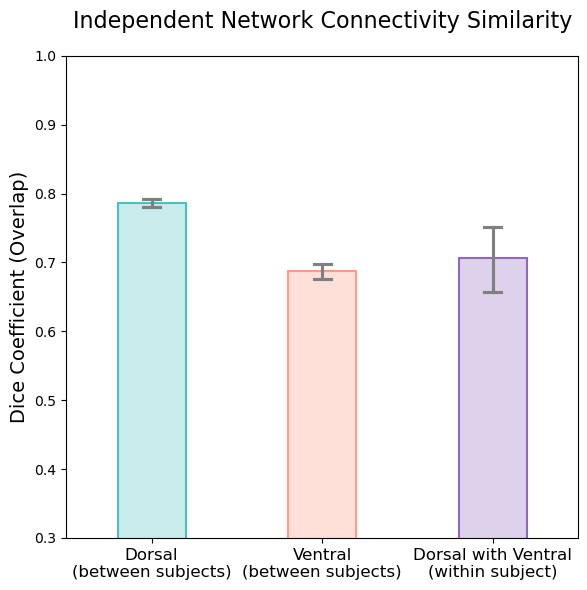


RESULTS (left to right on plot):
Dorsal between-subject:     0.786 (78.6%)
Ventral between-subject:    0.687 (68.7%)
Within-subject (D↔V):       0.706 (70.6%)

Visualization complete!


In [7]:
# Cell 5: Visualization - Independent Networks (matching original FC style)
# Using the exact same design/order/layout as the original FC figure

print("CREATING INDEPENDENT NETWORKS VISUALIZATION")
print("="*45)

# Prepare data for plotting (matching original structure)
plot_data = []

# Add between-subject dorsal data (left position)
for dice_val in between_dorsal_results['dice_values']:
    plot_data.append({
        'Comparison': 'Dorsal\n(between subjects)',
        'Dice': dice_val
    })

# Add between-subject ventral data (middle position)
for dice_val in between_ventral_results['dice_values']:
    plot_data.append({
        'Comparison': 'Ventral\n(between subjects)',
        'Dice': dice_val
    })

# Add within-subject data (right position)
for dice_val in within_subject_results['dice_values']:
    plot_data.append({
        'Comparison': 'Dorsal with Ventral\n(within subject)',
        'Dice': dice_val
    })

# Convert to DataFrame
plot_df = pd.DataFrame(plot_data)

# Define order (EXACT same as original FC figure)
order = ['Dorsal\n(between subjects)', 'Ventral\n(between subjects)', 'Dorsal with Ventral\n(within subject)']

# Define color mapping (EXACT same as original)
color_map = {
    'Dorsal with Ventral\n(within subject)': '#9467bd',  # Purple
    'Dorsal\n(between subjects)': '#4ac0c0',              # Teal
    'Ventral\n(between subjects)': '#ff9b83'              # Peach
}

# Create the plot (EXACT same parameters as original)
fig, ax = plt.subplots(figsize=(6, 6))

# Create the main bar plot using seaborn.barplot()
sns.barplot(
    x='Comparison', 
    y='Dice', 
    data=plot_df, 
    order=order, 
    palette=color_map, 
    ax=ax,
    ci=95,  # Automatically calculates and plots the 95% CI
    capsize=0.1,  # Adds small caps to the error bars
    errcolor='gray', # Sets the color of the error bars
    width=0.4 # Makes the bars narrower
)

# Set semi-transparent bar colors (EXACT same method as original)
for i, bar in enumerate(ax.patches):
    color = color_map[order[i]]
    rgb = plt.cm.colors.to_rgb(color)
    bar.set_facecolor((*rgb, 0.3)) # Set face color with 30% opacity
    bar.set_edgecolor(color)       # Keep the original outline color
    bar.set_linewidth(1.5)

# Final Plot Customization (EXACT same as original)
ax.set_ylabel('Dice Coefficient (Overlap)', fontsize=14)
ax.set_xlabel('')  # Remove x-axis label as category labels are clear
ax.set_title('Independent Network Connectivity Similarity', fontsize=16, pad=20)
ax.set_ylim([0.3, 1.0])

# Ensure x-tick labels are readable
plt.xticks(fontsize=12)

# Adjust layout to prevent labels from being cut off
plt.tight_layout()

# Save the figure
output_dir = f'{results_dir}/independent_network_analysis'
os.makedirs(output_dir, exist_ok=True)
save_path = f'{output_dir}/independent_network_dice_coefficient_barplot.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Saved Independent Networks visualization to: {save_path}")

# Display the plot
plt.show()

# Print summary in the EXACT order of the plot
print(f"\nRESULTS (left to right on plot):")
print(f"Dorsal between-subject:     {between_dorsal_results['mean']:.3f} ({between_dorsal_results['mean']:.1%})")
print(f"Ventral between-subject:    {between_ventral_results['mean']:.3f} ({between_ventral_results['mean']:.1%})")  
print(f"Within-subject (D↔V):       {within_subject_results['mean']:.3f} ({within_subject_results['mean']:.1%})")

print(f"\nVisualization complete!")